In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
%matplotlib inline

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)

In [39]:
resDir = Path("../results")
dataDirRaw = Path("../data/newMEGdata")
dataDirFilter = Path("../data/MEG_DKRegion_TimeCourses")

In [75]:
datFilRaw = list(dataDirRaw.glob("*02*min.mat"))[0]
datFilFilter = list(dataDirFilter.glob("*02*min.mat"))[0]
print(datFilRaw)
print(datFilFilter)

../data/newMEGdata/lcmv_result_R2868E_02-st_wo_filtering_min.mat
../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_02-st_DKregionmin.mat


In [76]:
gtF = list(dataDir.glob("*_03_st.txt"))[0]
gtSt03 = time2pts(txt2Time(gtF), timeLims.st03)

In [77]:
txt2Time(gtF)

[22.2866666667,
 32.8766666667,
 42.4933333333,
 53.9166666667,
 68.9333333333,
 78.1666666667]

In [78]:
timeLims.st03

[20, 80]

In [79]:
gtSt03.cpts

array([ 274, 1545, 2699, 4070, 5871, 6980])

In [80]:
np.diff(gtSt03.cpts)

array([1271, 1154, 1371, 1801, 1109])

In [81]:
from scipy.signal import lfilter, firls, decimate

In [82]:
q = 10

## Plot the data

In [83]:
MEGRaw = loadmat(datFilRaw)
MEGFilter = loadmat(datFilFilter)

In [84]:
dataRaw = MEGRaw["DK_timecourse"]
dataFilter = MEGFilter["DK_timecourse"]

In [85]:
q = 10
dataRawN = decimate(dataRaw, q=q)
dataRawN = detrend(dataRawN)
dataFilterN = decimate(dataFilter, q=q)
dataFilterN = detrend(dataFilterN)

In [92]:
fs = 120 #sampling frequency
fmin = 1 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass

In [93]:
dataRawHPF = lfilter(hbp, 1, dataRawN)
dataFilterHPF = lfilter(hbp, 1, dataFilterN)

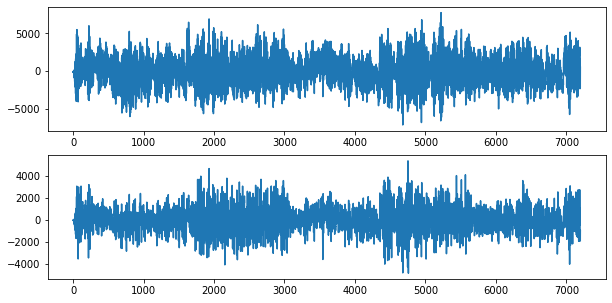

In [96]:
plt.figure(figsize=(10, 5))

idx = 10
#plt.subplot(211)
#plt.plot(dataRawN[idx, :])
#plt.subplot(212)
#plt.plot(dataFilterN[idx, :])
plt.subplot(211)
plt.plot(dataRawHPF[idx, :])
plt.subplot(212)
plt.plot(dataFilterHPF[idx, :])

## Detection on data without HPF

In [20]:
paras = edict()
paras.Lmin = 200
paras.wh = 10 
paras.MaxM = 20
paras.fct = 0.5
paras.r = 12 
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

In [21]:
detRaw = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir=None, 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 12}


In [22]:
detRaw.Screening(wh=paras.wh)

In [23]:
detRaw()

In [24]:
kappas = np.linspace(1, 4, 1000)
detRaw.TuningKappa(kappas)

+-------------+----------------+-------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE        | Rank |
+-------------+----------------+-------------------+------+
|      0      |       []       | 47427264120.34318 |  12  |
+-------------+----------------+-------------------+------+


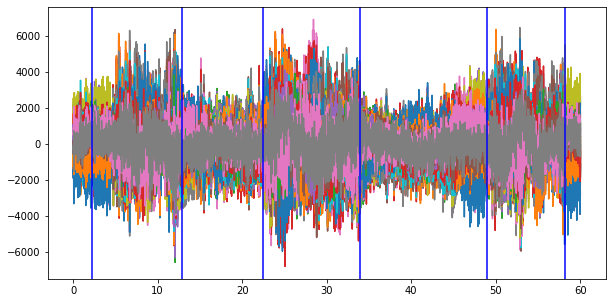

In [25]:
detRaw.UpdateEcpts()
print(detRaw)
detRaw.PlotEcpts(GT=gtSt03.cpts)

+-------------+---------------------------------------------------------+-------------------+------+
| Num of CPTs |                      Estiamted CPTs                     |        MSE        | Rank |
+-------------+---------------------------------------------------------+-------------------+------+
|      9      | [ 587. 1564. 1825. 2786. 3438. 4101. 5887. 6453. 7000.] | 216273159386008.4 |  12  |
+-------------+---------------------------------------------------------+-------------------+------+


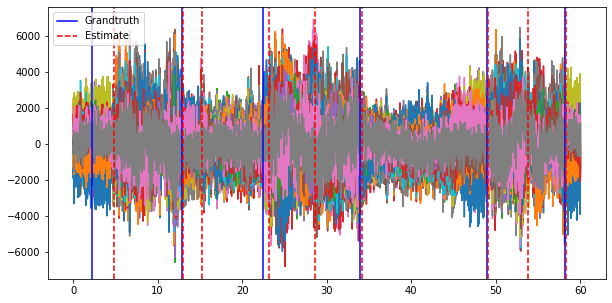

In [30]:
detRaw.UpdateEcpts(9)
print(detRaw)
detRaw.PlotEcpts(GT=gtSt03.cpts)

## Detection after HPF 

**Good**

wh = 10


In [39]:
dataHPF.shape

(68, 7200)

In [40]:
detHPF = TVDNDetect1(Ymat=dataHPF, dataType="MEG", 
                     saveDir=None, 
                     fName="HPF1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'HPF1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 12}


In [41]:
detHPF.Screening(wh=paras.wh)#

In [42]:
detHPF()

In [43]:
kappas = np.linspace(1, 4, 1000)
detHPF.TuningKappa(kappas)

+-------------+----------------+--------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE         | Rank |
+-------------+----------------+--------------------+------+
|      0      |       []       | 141063.78161227718 |  12  |
+-------------+----------------+--------------------+------+


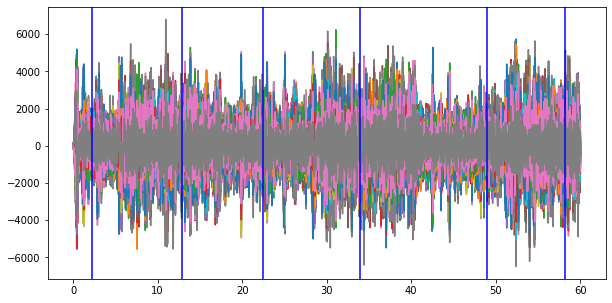

In [44]:
detHPF.UpdateEcpts()
print(detHPF)
detHPF.PlotEcpts(GT=gtSt03.cpts)

+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [ 202.  774. 1918. 3480. 4902. 6200.] | 19858490943673.414 |  12  |
+-------------+---------------------------------------+--------------------+------+


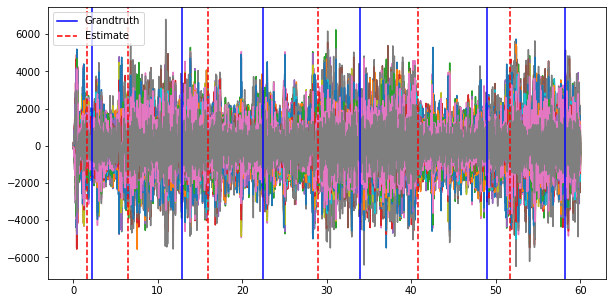

In [46]:
detHPF.UpdateEcpts(6)
print(detHPF)
detHPF.PlotEcpts(GT=gtSt03.cpts)